### BÀI TOÁN: K-means phân cụm khu vực theo (Lưu lượng giao thông, Diện tích) ###


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Chuẩn bị dữ liệu

Tạo DataFrame từ dữ liệu bảng với 8 khu vực (KV0-KV7), mỗi khu vực có 2 thuộc tính:
- **Lưu lượng giao thông**: số lượng phương tiện (đơn vị: xe)
- **Diện tích**: diện tích khu vực (đơn vị: km²)

Dữ liệu này sẽ được dùng để phân cụm các khu vực có đặc điểm tương tự nhau.

In [21]:
# Dữ liệu từ bảng trong đề bài
data = {
    "Ma_KV": ["KV0", "KV1", "KV2", "KV3", "KV4", "KV5", "KV6", "KV7"],
    "Luu_luong": [8000, 3000, 12000, 2000, 5000, 6000, 15000, 4000],
    "Dien_tich": [5.0, 3.0, 7.0, 2.0, 5.5, 6.0, 8.0, 3.0],
}
df = pd.DataFrame(data)
print("Dữ liệu ban đầu:")
print(df)

Dữ liệu ban đầu:
  Ma_KV  Luu_luong  Dien_tich
0   KV0       8000        5.0
1   KV1       3000        3.0
2   KV2      12000        7.0
3   KV3       2000        2.0
4   KV4       5000        5.5
5   KV5       6000        6.0
6   KV6      15000        8.0
7   KV7       4000        3.0


## 2. Chuẩn hóa dữ liệu (Z-score Normalization)

### Tại sao cần chuẩn hóa?
- **Lưu lượng** có giá trị lớn (2000-15000) 
- **Diện tích** có giá trị nhỏ (2-8)
- Nếu không chuẩn hóa, thuộc tính có giá trị lớn hơn sẽ chi phối kết quả clustering

### Công thức Z-score:
$$X_{std} = \frac{X - \mu}{\sigma}$$

Sau khi chuẩn hóa, dữ liệu có mean = 0 và std = 1, giúp các thuộc tính có trọng số ngang nhau.

### Hàm giải chuẩn hóa (inverse transform):
Chuyển đổi dữ liệu đã chuẩn hóa về đơn vị gốc để dễ hiểu kết quả:
$$X = X_{std} \times \sigma + \mu$$

In [22]:
def zscore_fit_transform(X: np.ndarray):
    """
    Chuẩn hóa Z-score: X_std = (X - mean) / std
    Args:
        X: mảng dữ liệu cần chuẩn hóa (n_samples, n_features)
    Returns:
        X_std: dữ liệu đã chuẩn hóa
        mean: giá trị trung bình của mỗi feature
        std: độ lệch chuẩn của mỗi feature
    """
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)  # ddof=0 để tính population std
    # Tránh chia cho 0 nếu có cột hằng số
    std = np.where(std == 0, 1.0, std)
    X_std = (X - mean) / std
    return X_std, mean, std
def zscore_inverse_transform(X_std: np.ndarray, mean: np.ndarray, std: np.ndarray):
    """
    Giải chuẩn hóa Z-score để quay về đơn vị gốc.
    Args:
        X_std: dữ liệu đã chuẩn hóa
        mean: giá trị trung bình đã lưu từ quá trình chuẩn hóa
        std: độ lệch chuẩn đã lưu từ quá trình chuẩn hóa
    Returns:
        X: dữ liệu ở đơn vị gốc
    """
    return X_std * std + mean

## 3. Khởi tạo K-means++ (Smart Initialization)

### Vấn đề của random initialization:
- Khởi tạo ngẫu nhiên có thể cho kết quả không tối ưu
- Các centroid ban đầu có thể gần nhau → hội tụ chậm

### K-means++ Algorithm:
1. **Bước 1**: Chọn ngẫu nhiên điểm đầu tiên làm centroid đầu tiên
2. **Bước 2**: Với mỗi điểm dữ liệu, tính khoảng cách bình phương (D²) đến centroid gần nhất
3. **Bước 3**: Chọn điểm tiếp theo làm centroid mới với xác suất tỉ lệ với D²
   - Điểm xa các centroid hiện tại có xác suất cao được chọn
4. **Lặp lại** bước 2-3 cho đến khi có đủ K centroids

### Lợi ích:
- Các centroids ban đầu được phân tán tốt hơn
- Hội tụ nhanh hơn và kết quả ổn định hơn

In [23]:
def kmeans_pp_init(X: np.ndarray, k: int, rng: np.random.Generator):
    """
    Khởi tạo tâm cụm theo thuật toán K-means++
    Args:
        X: dữ liệu (n_samples, n_features)
        k: số lượng clusters
        rng: random number generator
    Returns:
        centroids: k centroids ban đầu (k, n_features)
    """
    n = X.shape[0]
    centroids = np.empty((k, X.shape[1]), dtype=float)
    # Chọn centroid đầu tiên ngẫu nhiên
    idx0 = rng.integers(0, n)
    centroids[0] = X[idx0]
    # Tính khoảng cách bình phương đến centroid đầu tiên
    dist2 = np.sum((X - centroids[0]) ** 2, axis=1)
    # Chọn các centroid tiếp theo
    for c in range(1, k):
        # Trường hợp đặc biệt: tất cả điểm trùng nhau
        if np.all(dist2 == 0):
            idx = rng.integers(0, n)
            centroids[c] = X[idx]
            continue
        # Chọn điểm mới với xác suất tỉ lệ với D²
        probs = dist2 / dist2.sum()
        idx = rng.choice(n, p=probs)
        centroids[c] = X[idx]
        # Cập nhật khoảng cách: D² = min(D² hiện tại, D² đến centroid mới)
        new_dist2 = np.sum((X - centroids[c]) ** 2, axis=1)
        dist2 = np.minimum(dist2, new_dist2)
    return centroids

## 4. Thuật toán K-means từ đầu (From Scratch)
**BƯỚC 1: Khởi tạo giá trị của K**
- Xác định số lượng clusters K mong muốn (input từ người dùng)

**BƯỚC 2: Chọn ngẫu nhiên K tâm cụm**
- Khởi tạo K centroids ban đầu (sử dụng K-means++ để tối ưu)
- K-means++ giúp chọn các centroids phân tán tốt hơn random thuần

**BƯỚC 3: Gán mỗi điểm dữ liệu vào một cụm**
- Tính khoảng cách Euclidean từ mỗi điểm đến tất cả K centroids
- Gán mỗi điểm vào cluster có centroid gần nhất (khoảng cách nhỏ nhất)
$$d(x_i, c_j) = \sqrt{\sum_{d=1}^{n} (x_{id} - c_{jd})^2}$$

**BƯỚC 4: Tính toán tâm cụm mới của mỗi cụm**
- Cập nhật mỗi centroid = trung bình tọa độ của tất cả điểm trong cluster đó
$$c_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i$$
- Xử lý trường hợp cluster rỗng: chọn điểm xa nhất làm centroid mới

**BƯỚC 5: Lặp lại Bước 3 và 4 cho đến khi hội tụ rồi dừng lại.**
- Lặp lại Assignment (Step 3) và Update (Step 4)
- Dừng khi: Inertia thay đổi < threshold (hội tụ) hoặc đạt max iterations

### Inertia (Within-Cluster Sum of Squares):
Đo chất lượng clustering - tổng bình phương khoảng cách từ điểm đến centroid:
$$\text{Inertia} = \sum_{j=1}^{K} \sum_{x_i \in C_j} ||x_i - c_j||^2$$

### Multiple Runs (n_init):
- Chạy thuật toán n_init lần với khởi tạo khác nhau (Step 2)
- Chọn kết quả có Inertia nhỏ nhất (chất lượng tốt nhất)

In [24]:
class KMeansScratch:
    """
    Thuật toán K-means clustering from scratch theo procedure chuẩn 5 bước.
    
    Procedure:
    - STEP 1: Initialize the value of K
    - STEP 2: Select random K centroids
    - STEP 3: Assign each data point to a cluster
    - STEP 4: Calculate a new centroid of each cluster
    - STEP 5: Repeat step 3 and 4 until convergent then stop
    """
    
    def __init__(self, k, max_iters=100, tol=1e-8, random_state=42, verbose=True):
        """
        Args:
            k: số lượng clusters (STEP 1)
            max_iters: số vòng lặp tối đa
            tol: ngưỡng hội tụ
            random_state: seed cho random
            verbose: hiển thị chi tiết từng bước
        """
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.verbose = verbose
        self.centroids = None
        self.labels = None
        self.inertia_ = None
        self.n_iters_ = None

    def _assign_labels(self, X):
        """
        STEP 3: Assign each data point to a cluster
        Tính khoảng cách và gán mỗi điểm vào cluster gần nhất
        """
        # Tính khoảng cách bình phương từ mỗi điểm đến tất cả centroids
        dist2 = np.sum((X[:, None, :] - self.centroids[None, :, :]) ** 2, axis=2)
        # Gán nhãn = cluster có khoảng cách nhỏ nhất
        return np.argmin(dist2, axis=1)
    def _update_centroids(self, X):
        """
        STEP 4: Calculate a new centroid of each cluster
        Cập nhật centroid = trung bình các điểm trong cluster
        """
        new_centroids = np.zeros_like(self.centroids)
        rng = np.random.default_rng(self.random_state)
        for j in range(self.k):
            pts = X[self.labels == j]
            if len(pts) > 0:
                # Centroid = trung bình tọa độ các điểm trong cluster
                new_centroids[j] = pts.mean(axis=0)
            else:
                # Xử lý cụm rỗng: chọn ngẫu nhiên 1 điểm làm centroid mới
                new_centroids[j] = X[rng.integers(0, X.shape[0])]
        return new_centroids
    def _compute_inertia(self, X):
        """Tính Inertia (SSE): tổng bình phương khoảng cách từ điểm đến centroid"""
        return float(np.sum((X - self.centroids[self.labels]) ** 2))
    def fit(self, X):
        """
        Fit K-means theo procedure chuẩn 5 bước
        Args:
            X: dữ liệu (n_samples, n_features)
        Returns:
            self
        """
        n = X.shape[0]
        # Validation
        if self.k < 1:
            raise ValueError("k phải >= 1")
        if self.k > n:
            raise ValueError(f"k={self.k} > số điểm n={n}. Không hợp lệ.")
        # STEP 1: Initialize the value of K (đã có self.k)
        if self.verbose:
            print("="*70)
            print(f"STEP 1: Initialize K = {self.k}")
            print("="*70)
        # STEP 2: Select random K centroids
        np.random.seed(self.random_state)
        init_idx = np.random.choice(n, self.k, replace=False)
        self.centroids = X[init_idx].copy()
        if self.verbose:
            print(f"STEP 2: Select random {self.k} centroids")
            print(f"  → Chọn các điểm có index: {init_idx.tolist()}")
            print(f"  → Centroids ban đầu (normalized):")
            for j, c in enumerate(self.centroids):
                print(f"      Cluster {j}: {c}")
            print("="*70)
        # STEP 5: Repeat STEP 3 and STEP 4 until convergent
        for it in range(1, self.max_iters + 1):
            old_centroids = self.centroids.copy()
            # STEP 3: Assign each data point to a cluster
            self.labels = self._assign_labels(X)
            # STEP 4: Calculate a new centroid of each cluster
            self.centroids = self._update_centroids(X)
            # Tính inertia
            self.inertia_ = self._compute_inertia(X)
            if self.verbose:
                print(f"\n--- Iteration {it} ---")
                print(f"STEP 3 (Assignment): labels = {self.labels.tolist()}")
                print(f"STEP 4 (Update): centroids (normalized):")
                for j, c in enumerate(self.centroids):
                    print(f"  Cluster {j}: {c}")
                print(f"Inertia (SSE normalized): {self.inertia_:.6f}")
            # STEP 5: Check convergence (điều kiện dừng)
            if np.allclose(old_centroids, self.centroids, atol=self.tol):
                self.n_iters_ = it
                if self.verbose:
                    print(f"\n✓ HỘI TỤ sau {it} iterations!")
                    print("="*70)
                break
        else:
            self.n_iters_ = self.max_iters
            if self.verbose:
                print(f"\n⚠ Đạt max_iters={self.max_iters} mà chưa hội tụ!")
        return self

## 5. Phần (a): Phân cụm với K = 3

### Quy trình thực hiện:
1. **Trích xuất features**: Lấy 2 cột "Lưu lượng" và "Diện tích" từ DataFrame
2. **Chuẩn hóa**: Áp dụng Z-score normalization
3. **Chạy K-means**: 
   - K = 3 (theo yêu cầu đề bài)
   - n_init = 30 (chạy 30 lần với khởi tạo khác nhau)
   - random_state = 7 (để kết quả có thể tái tạo)
4. **Giải chuẩn hóa centroids**: Chuyển về đơn vị gốc để dễ hiểu
5. **Hiển thị kết quả**: In bảng phân cụm và thông tin centroids

In [25]:
# Trích xuất features để clustering
features = ["Luu_luong", "Dien_tich"]
X = df[features].to_numpy(dtype=float)

# Chuẩn hóa dữ liệu (tránh "lưu lượng" lấn át "diện tích")
X_std, mean_, std_ = zscore_fit_transform(X)

print("Dữ liệu sau khi chuẩn hóa (Z-score):")
print("X_normalized shape:", X_std.shape)
print("Mean:", mean_)
print("Std:", std_)
print()

# ================================================================
# Chạy K-means với K = 3 (verbose=True để xem chi tiết)
# ================================================================
K = 3
kmeans3 = KMeansScratch(k=K, max_iters=300, tol=1e-8, random_state=42, verbose=True)
kmeans3.fit(X_std)

# Lấy kết quả
labels = kmeans3.labels
centroids_std = kmeans3.centroids
inertia = kmeans3.inertia_
n_iters = kmeans3.n_iters_

# Giải chuẩn hóa centroids để xem theo đơn vị gốc
centroids_original = zscore_inverse_transform(centroids_std, mean_, std_)

# Thêm cột Cluster vào DataFrame
df_result = df.copy()
df_result["Cluster"] = labels

# In kết quả tổng hợp
print("\n" + "="*70)
print("KẾT QUẢ PHÂN CỤM (K=3)")
print("="*70)
print(df_result.sort_values("Cluster").to_string(index=False))

print("\n📍 Tâm cụm (centroid) theo đơn vị gốc [Luu_luong, Dien_tich]:")
for i, c in enumerate(centroids_original):
    print(f"  Cụm {i}: Luu_luong={c[0]:>8.2f}, Dien_tich={c[1]:>6.2f}")

print(f"\n📊 Inertia (SSE) trên dữ liệu chuẩn hóa: {inertia:.6f}")
print(f"🔄 Số vòng lặp hội tụ: {n_iters}")
print("="*70)

Dữ liệu sau khi chuẩn hóa (Z-score):
X_normalized shape: (8, 2)
Mean: [6.8750e+03 4.9375e+00]
Std: [4.25551113e+03 1.97543508e+00]

STEP 1: Initialize K = 3
STEP 2: Select random 3 centroids
  → Chọn các điểm có index: [1, 5, 0]
  → Centroids ban đầu (normalized):
      Cluster 0: [-0.91058392 -0.9807966 ]
      Cluster 1: [-0.20561572  0.5378562 ]
      Cluster 2: [0.26436307 0.0316386 ]

--- Iteration 1 ---
STEP 3 (Assignment): labels = [2, 0, 2, 0, 1, 1, 2, 0]
STEP 4 (Update): centroids (normalized):
  Cluster 0: [-0.91058392 -1.14953579]
  Cluster 1: [-0.32311042  0.4113018 ]
  Cluster 2: [1.12599087 0.8753346 ]
Inertia (SSE normalized): 2.898876

--- Iteration 2 ---
STEP 3 (Assignment): labels = [1, 0, 2, 0, 1, 1, 2, 0]
STEP 4 (Update): centroids (normalized):
  Cluster 0: [-0.91058392 -1.14953579]
  Cluster 1: [-0.12728592  0.2847474 ]
  Cluster 2: [1.55680476 1.29718259]
Inertia (SSE normalized): 1.043717

--- Iteration 3 ---
STEP 3 (Assignment): labels = [1, 0, 2, 0, 1, 1, 2, 0

## 6. Trực quan hóa kết quả phân cụm K = 3

### Biểu đồ scatter plot gồm:
- **Trục X**: Lưu lượng giao thông (đơn vị gốc)
- **Trục Y**: Diện tích (đơn vị gốc)
- **Màu sắc**: Phân biệt các clusters khác nhau
- **Dấu X lớn**: Vị trí các centroids (đã giải chuẩn hóa)
- **Nhãn**: Mã khu vực (KV0-KV7) cạnh mỗi điểm

Biểu đồ giúp quan sát:
- Các khu vực trong cùng 1 cluster gần nhau về cả lưu lượng và diện tích
- Centroids nằm ở vị trí trung tâm của mỗi cluster

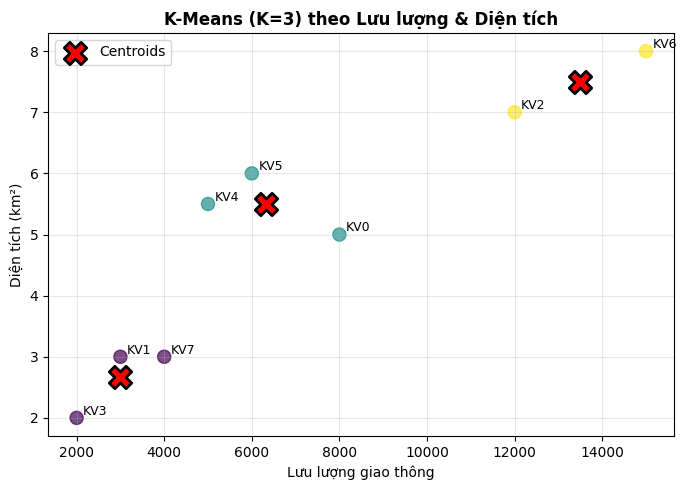

In [27]:
# Vẽ biểu đồ scatter với màu sắc theo cluster
plt.figure(figsize=(7, 5))

# Vẽ các điểm dữ liệu, màu theo cluster
plt.scatter(df["Luu_luong"], df["Dien_tich"], c=labels, s=90, cmap='viridis', alpha=0.7)

# Vẽ centroids (dấu X lớn màu đỏ)
plt.scatter(centroids_original[:, 0], centroids_original[:, 1], 
           marker="X", s=260, c='red', edgecolors='black', linewidths=2, label='Centroids')

# Thêm nhãn cho mỗi điểm
for _, row in df_result.iterrows():
    plt.text(row["Luu_luong"] + 150, row["Dien_tich"] + 0.05, 
            row["Ma_KV"], fontsize=9, ha='left')

plt.title("K-Means (K=3) theo Lưu lượng & Diện tích", fontsize=12, fontweight='bold')
plt.xlabel("Lưu lượng giao thông", fontsize=10)
plt.ylabel("Diện tích (km²)", fontsize=10)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Phần (b): Phương pháp Elbow để xác định K tối ưu

### Phương pháp Elbow là gì?
- Chạy K-means với nhiều giá trị K khác nhau (từ 1 đến 9)
- Tính Inertia (SSE) cho mỗi giá trị K
- Vẽ biểu đồ K vs Inertia

### Quan sát biểu đồ:
- **K nhỏ**: Inertia cao (các điểm xa centroid)
- **K tăng dần**: Inertia giảm nhanh
- **"Khuỷu tay" (Elbow)**: Điểm mà tốc độ giảm inertia chậm lại đột ngột
- **K lớn**: Inertia tiếp tục giảm nhưng chậm hơn

### Cách chọn K tối ưu:
- Chọn K tại điểm "khuỷu tay" - nơi đường cong bắt đầu "nằm ngang"
- Đây là trade-off tốt giữa:
  - **Số clusters ít** (đơn giản, dễ hiểu)
  - **Inertia thấp** (chất lượng clustering tốt)

### Lưu ý:
- Với 8 điểm dữ liệu, K > 8 không hợp lệ (mỗi điểm là 1 cluster riêng)

In [26]:
# Chạy K-means với K từ 1 đến 9
Ks = list(range(1, 10))
inertias = []

n_points = X_std.shape[0]  # Số điểm dữ liệu (8 điểm)

print("="*70)
print("ELBOW METHOD - Tính Inertia cho K từ 1 đến 9")
print("="*70)

for k in Ks:
    if k > n_points:
        # K > số điểm → không hợp lệ, gán NaN
        print(f"K={k}: không hợp lệ (K > số điểm n={n_points})")
        inertias.append(np.nan)
        continue
    
    # Chạy K-means với verbose=False để không hiển thị chi tiết
    km = KMeansScratch(k=k, max_iters=300, tol=1e-8, random_state=42, verbose=False)
    km.fit(X_std)
    inertias.append(km.inertia_)
    print(f"K={k}: Inertia = {km.inertia_:.6f}")

print("="*70)

ELBOW METHOD - Tính Inertia cho K từ 1 đến 9
K=1: Inertia = 16.000000
K=2: Inertia = 5.677141
K=3: Inertia = 1.043717
K=4: Inertia = 0.790050
K=5: Inertia = 0.463870
K=6: Inertia = 0.404228
K=7: Inertia = 0.376618
K=8: Inertia = 0.000000
K=9: không hợp lệ (K > số điểm n=8)


## 8. Vẽ biểu đồ Elbow

Biểu đồ này giúp xác định K tối ưu:
- **Trục X**: Số lượng clusters (K)
- **Trục Y**: Inertia/SSE
- **Tìm "khuỷu tay"**: Điểm mà đường cong gãy khúc rõ ràng

**Kết luận**: 
- Quan sát biểu đồ để tìm điểm elbow
- Thường K = 2 hoặc K = 3 là lựa chọn phù hợp cho bài toán này
- Tại K = 3, inertia giảm đáng kể so với K = 2
- Với K > 3, inertia giảm ít hơn → không cần thiết phải tăng độ phức tạp

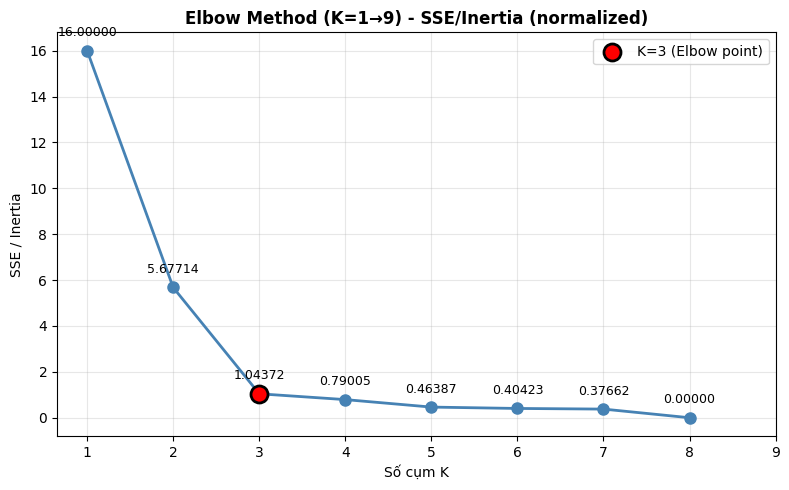


📊 KẾT LUẬN:
✓ Dựa vào biểu đồ Elbow, K tối ưu nên chọn là 3.
✓ Tại K=3, đường cong có điểm 'khuỷu tay' rõ ràng.
✓ Tăng K lên cao hơn không cải thiện đáng kể chất lượng clustering.


In [ ]:
# Vẽ biểu đồ Elbow
plt.figure(figsize=(8, 5))
plt.plot(Ks, inertias, marker="o", linewidth=2, markersize=8, color='steelblue')

# Đánh dấu điểm K=3 (thường là elbow point)
valid_k3_idx = Ks.index(3)
plt.scatter([3], [inertias[valid_k3_idx]], color='red', s=150, zorder=5, 
           label=f'Elbow point', edgecolors='black', linewidths=2)

for i, k in enumerate(Ks):
    if not np.isnan(inertias[i]):
        plt.text(k, inertias[i] + 0.5, f"{inertias[i]:.5f}", 
                 fontsize=9, ha='center', va='bottom')
        
plt.title("Elbow Method (K=1→9) - SSE/Inertia (normalized)", fontsize=12, fontweight='bold')
plt.xlabel("Số cụm K", fontsize=10)
plt.ylabel("SSE / Inertia", fontsize=10)
plt.xticks(Ks)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("📊 KẾT LUẬN:")
print("="*70)
print("✓ Dựa vào biểu đồ Elbow, K tối ưu nên chọn là 3.")
print("✓ Tại K=3, đường cong có điểm 'khuỷu tay' rõ ràng.")
print("✓ Tăng K lên cao hơn không cải thiện đáng kể chất lượng clustering.")
print("="*70)